In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import info_utilities

In [2]:
data_folder = "../data/"

# Data loading and cleaning

## Users info

In [5]:
users      = pd.read_csv(f"{data_folder}users.csv")
users_info = pd.read_csv(f"{data_folder}users_info.csv",sep=";").set_index('attribute')

**Below the list of the columns and a short description**

In [6]:
users_info

,type,description
attribute,,
user_id,numeric,user id
archived,ordinal,"boolean: if a user is archived, is no more vis..."
user_type,mixed,types of the user in csv
classes,categorical,classes to which the user belongs
n_activities,interval,the number of user activities
n_recipes,interval,the number of user recipes
n_experiences,interval,the number of user experiences
n_reflections,interval,the number of user reflections
n_recipe_reflections,interval,the number of user's recipies reflections


In [7]:
info_utilities.check_columns(users,users_info)

No extra columns in info
No extra columns in df


In the df are present those type of users:

We need only formatore (supervisor), docente (teacher) and studente (student)

In [8]:
# a little translation from italian
vals_to_replace = {'formatore':'supervisor', 'docente':'teacher', 'studente':'student'}
users.replace({"user_type":vals_to_replace}, inplace=True)

In [9]:
# One hot for user_type
users = pd.concat(
                [users.loc[:, :'user_type'], 
                 (users['user_type'].str.split('\s*,\s*', expand=True)
                   .stack()
                   .str.get_dummies()
                   .sum(level=0)), 
                 users.loc[:, 'classes':]], 
                axis=1)

In [10]:
interval_features = users_info[users_info['type']=='interval'].index.tolist()

In [11]:
# fill with 0 the interval features
users.loc[:,interval_features] = users[interval_features].fillna(0)

In [12]:
students    = users[users['student'] == 1]
supervisors = users[users['supervisor'] == 1]
teachers    = users[users['teacher'] == 1]

## Activities info

In [13]:
activities      = pd.read_csv(f"{data_folder}activities.csv")
activities_info = pd.read_csv(f"{data_folder}activities_info.csv", sep=";").set_index("attribute")

**Below the list of the columns and a short description**

In [14]:
activities_info

,type,description
attribute,,
activity_id,numeric,activity id
user_id,numeric,user id
at_activityType,categorical,"type of the activity ['recipe','experience']"
len_description,interval,the length of the description
ac_atSchool,ordinal,"boolean, if the recipe was done at school"
ac_atInteraziendale,ordinal,"boolean, if the recipe was done in an ""special..."
ac_atCompany,ordinal,"boolean, the recipe was done in the company"
avg_step_len,interval,average step length
n_steps,interval,the number of steps of the activity


In [15]:
info_utilities.check_columns(activities,activities_info)

There are 2 extra columns in info: ['activity_id', 'user_id']
There are 13 extra columns in df: ['len_observations', 'activity_total_length', 'std_reflection_length', 'len_bilancio', 'len_miglioramenti', 'len_competenze', 'activity_school_year', 'len_steps', 'n_edits', 'len_critici', 'ac_activity', 'std_step_len', 'us_user']


------

# Data exploring

## Users

In [16]:
corr_matrix = students.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
n = 5
top_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))[:n]

In [17]:
interesting_cols = list(set(list(zip(*top_corr.keys().values))[0]+list(zip(*top_corr.keys().values))[1]))

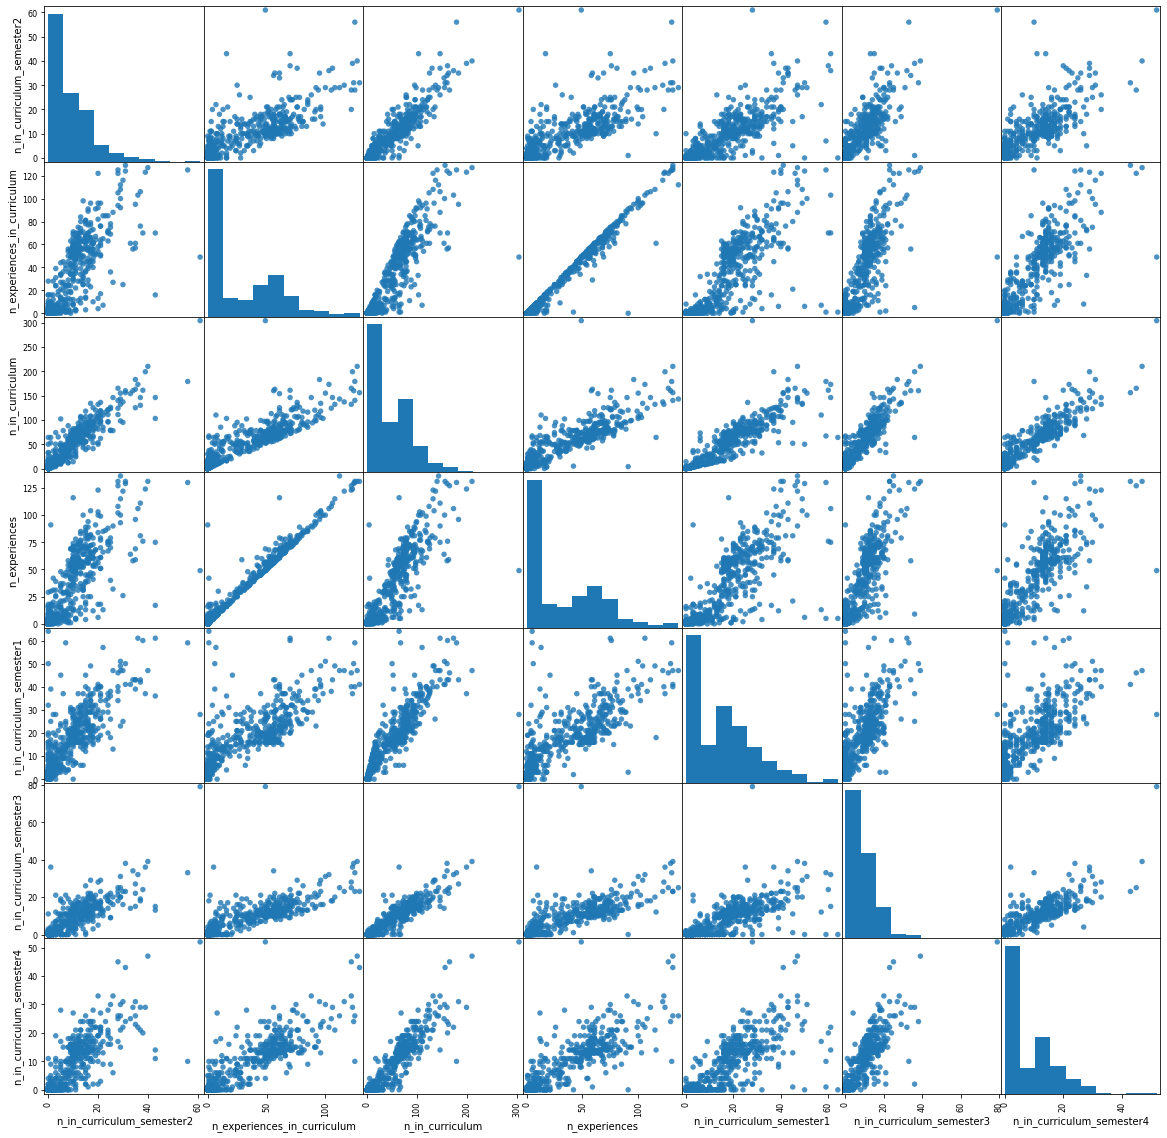

In [18]:
g = pd.plotting.scatter_matrix(students[interesting_cols], figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 30, alpha = 0.8)
plt.show()
#sns.pairplot(supervisors[supervisors_interesting_cols]);

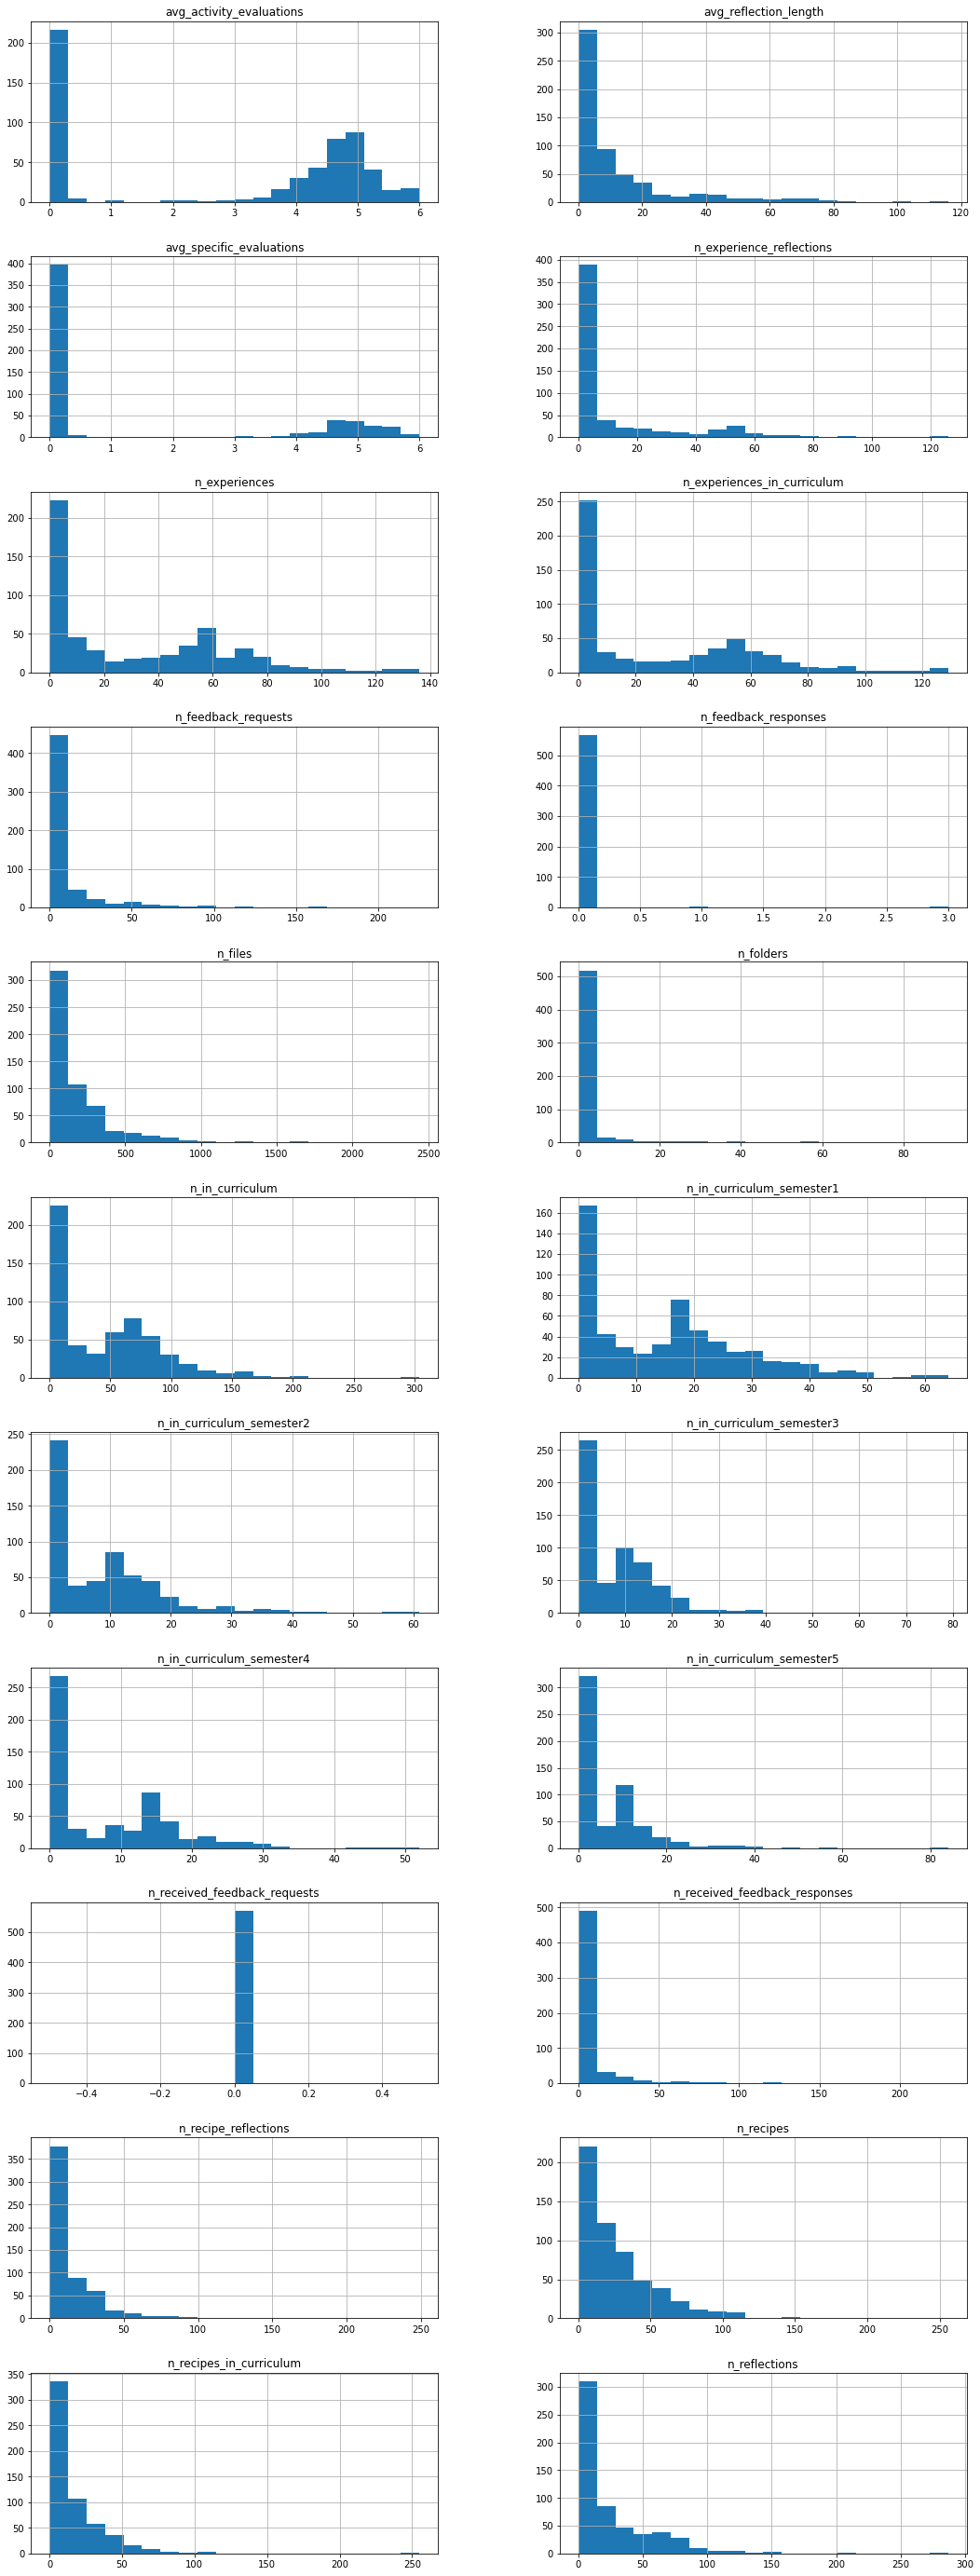

In [19]:
hist = students[interval_features].hist(bins=20,figsize=[18,50],layout=(11,2))

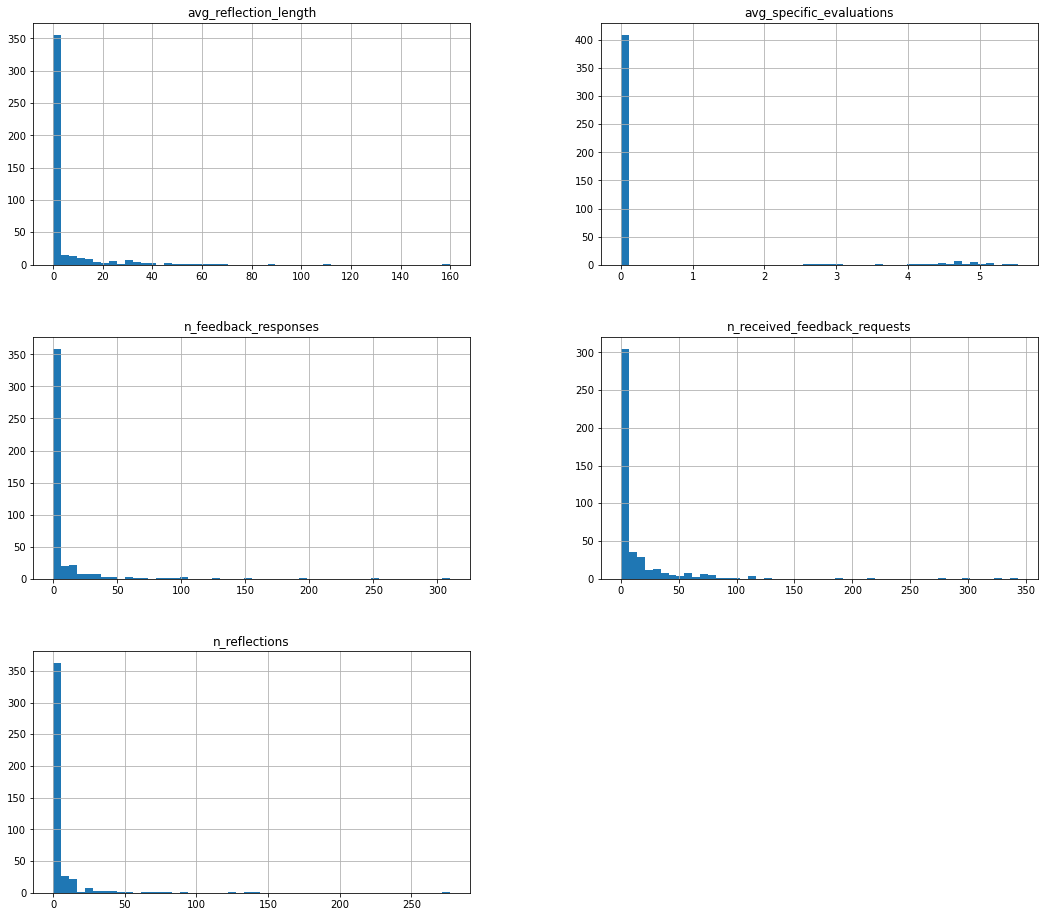

In [20]:
supervisors_interesting_cols = ['avg_reflection_length','avg_specific_evaluations','n_feedback_responses','n_received_feedback_requests','n_reflections']
hist = supervisors[supervisors_interesting_cols].hist(bins=50,figsize=[18,16],layout=(3,2))

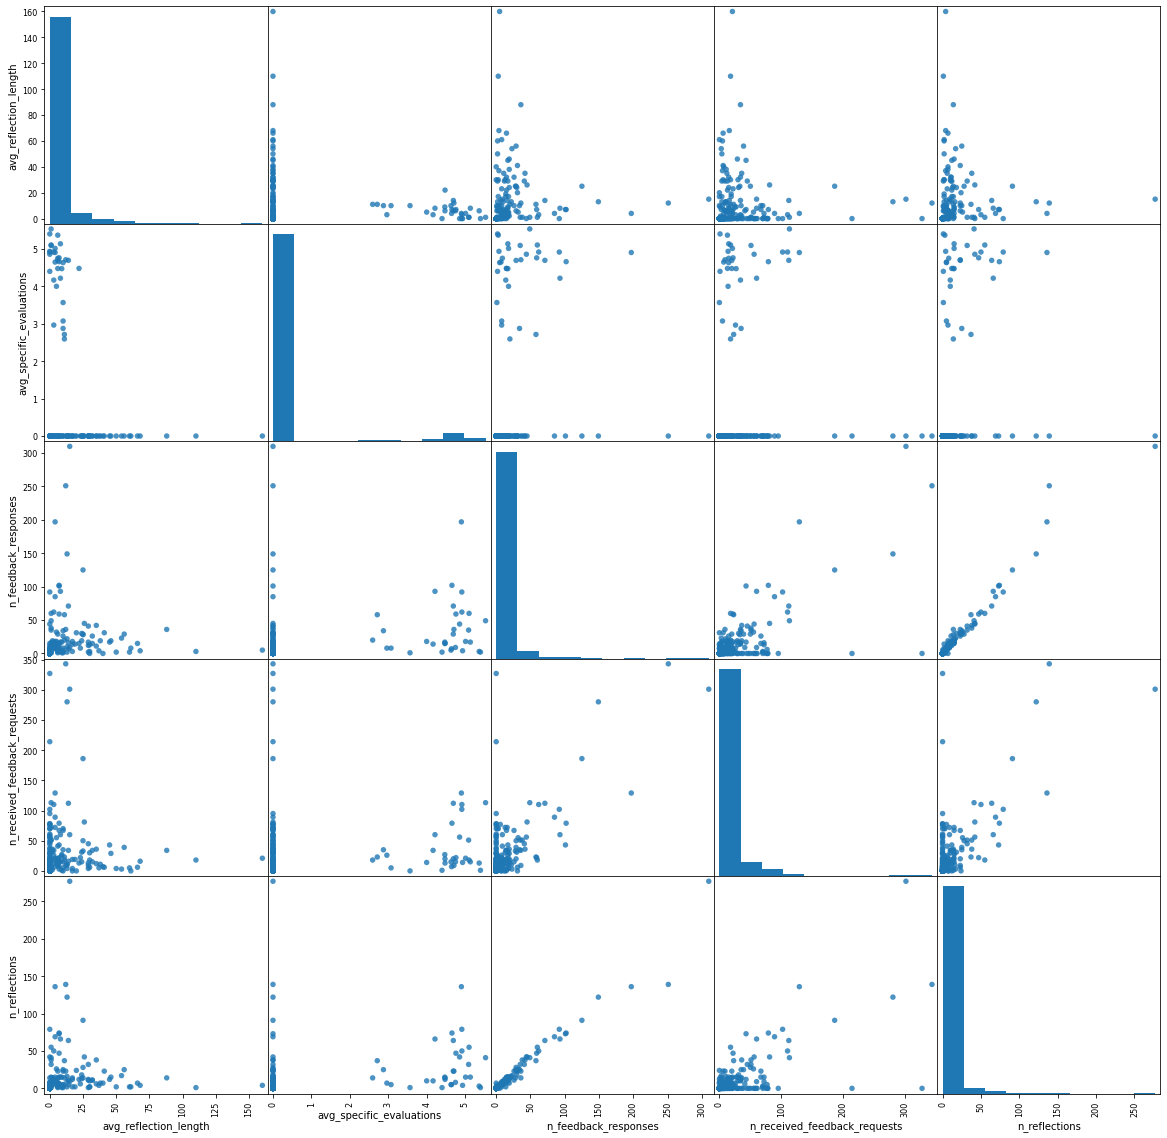

In [21]:
g = pd.plotting.scatter_matrix(supervisors[supervisors_interesting_cols], figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 30, alpha = 0.8)
plt.show()